# Stereoscope 

Following tutorial at: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/stereoscope_heart_LV_tutorial.html

In [1]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scvi.data import register_tensor_from_anndata
from scvi.external import RNAStereoscope, SpatialStereoscope

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Global seed set to 0
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load  data

### ST data

In [4]:
import os
input_dir = "../../../deconv/inputs/"
output_dir = "../../../deconv/results/stereoscope/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


    
sample = "Donor3_Wound7"
outdir = os.path.join(output_dir,sample)
if not os.path.exists(outdir):
    os.makedirs(outdir)
indir = os.path.join(input_dir,"st_data",sample)   
    

fh = open(os.path.join(indir, "rawdata_path.csv"),"r+")
raw_path = fh.read()
fh.close()
  
raw_path = raw_path.strip()
raw_path = "../" + raw_path
print(raw_path)   


../../../spatial/rawdata//Donor_3_4/P20063_107


In [5]:
adata_st = sc.read_visium(raw_path, library_id = sample)
adata_st.var_names_make_unique()
adata_st

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1749 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
# read in the barcodes
barcodes = pd.read_csv(os.path.join(indir, "barcodes.csv"), header = None)

# subset
adata_st = adata_st[adata_st.obs.index.isin(barcodes[0]),:]
adata_st

View of AnnData object with n_obs × n_vars = 1725 × 36600
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### SC data

In [88]:
sc_dir = '../../../scRNAseq/results/'
sc_path = os.path.join(input_dir, "sc_data", "s1_subsampled.h5ad")
adata_sc = sc.read_h5ad(sc_path)
adata_sc

AnnData object with n_obs × n_vars = 9120 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'SCT_snn_res.0.8', 'cl.annot'
    var: 'features'

In [104]:
# has normalized counts in .X and counts in raw.X
# OBS! The raw matrix has numericals instead of gene names as var.index
adata_sc.raw.var.rename(columns = {'_index':'features'}, inplace = True)
adata_sc.raw.var.index = adata_sc.var.index


In [106]:
# Revert back to raw matrix to have all genes
adata_sc = adata_sc.raw.to_adata()


In [108]:
adata_sc.obs['cl.annot'].value_counts()

VE             385
Mast-cell      381
Granular-II    380
Mono-Mac       378
Th             376
FB-II          376
Spinous-I      374
MEL            374
Granular-I     373
Basal-I        368
PC-vSMC        368
FB-III         367
Spinous-II     367
FB-IV          367
Mac            367
Basal-II       366
NK-cell        366
Spinous-III    364
FB-I           352
DC             312
B-cell         292
Basal-III      290
Basal-IV       286
LE             283
LC             237
Mono-DC        235
Schwann        136
Name: cl.annot, dtype: int64

### Marker genes

In [11]:
deg_path = os.path.join(input_dir, "sc_data", "degs_fc0.5_pval0.01.txt")
genes = pd.read_csv(deg_path, header=None) 
genes

,0
0,KRT1
1,KRT10
2,KRTDAP
3,DMKN
4,LGALS7B
...,...
5116,R3HCC1
5117,RNASEH2C
5118,IGF2BP2
5119,GPR17


In [12]:
# check that the genes are in the datasets

print(genes.isin(adata_st.var_names).sum())
print(genes.isin(adata_sc.var_names).sum())


genes = list(genes[0])

0    5121
dtype: int64
0    5121
dtype: int64


## Learn cell-type specific gene expression from scRNA-seq data

scvi requires layers, so the counts matrix must be in the counts layer

In [29]:
adata_sc.layers["counts"] = adata_sc.X.copy()
adata_st.layers["counts"] = adata_st.X.copy()

Filter genes to be the same in both datasets, use only the DEG genes.


In [30]:
st_adata = adata_st[:, genes].copy()
sc_adata = adata_sc[:, genes].copy()

Setup the AnnData object

In [32]:
RNAStereoscope.setup_anndata(sc_adata, layer = "counts", labels_key = "cl.annot")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cl.annot"]                                             
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 9120 cells, 5121 vars, 1 batches, 
         27 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


Train the _scRNA-Seq_ model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 100/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:40<00:00,  3.41s/it, loss=1.3e+06, v_num=1]


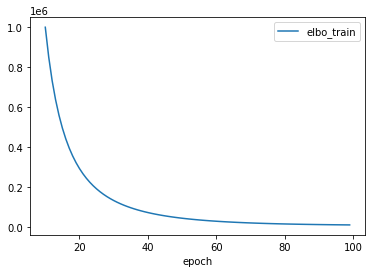

In [33]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs = 100)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", sc_adata)
    print("Loaded RNA model from file!")

## Infer proportion for spatial data

In [34]:
#st_adata.layers["counts"] = st_adata.X.copy()
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 1725 cells, 5121 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Train _Visium_ model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 10000/10000: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:37:56<00:00,  1.70it/s, loss=4.9e+06, v_num=1]


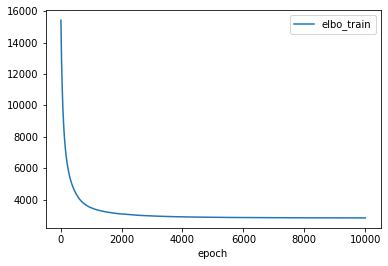

In [35]:
train=True
if train: 
    spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
    spatial_model.train(max_epochs = 10000)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", st_adata)
    print("Loaded Spatial model from file!")

## Deconvolution results 

In [36]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

In [37]:
st_adata.obsm["deconvolution"]

,B-cell,Basal-I,Basal-II,Basal-III,Basal-IV,DC,FB-I,FB-II,FB-III,FB-IV,...,Mono-DC,Mono-Mac,NK-cell,PC-vSMC,Schwann,Spinous-I,Spinous-II,Spinous-III,Th,VE
AAACCGGGTAGGTACC-1,1.436933e-06,5.682812e-03,5.924265e-06,4.781177e-07,1.207794e-06,5.202942e-07,7.751135e-07,3.645077e-02,7.746977e-01,6.340809e-07,...,1.729969e-05,1.385499e-06,5.971463e-07,9.828022e-07,8.252173e-07,3.729602e-03,5.181469e-06,2.033212e-07,4.566959e-07,1.090144e-06
AAACCGTTCGTCCAGG-1,2.378248e-07,2.662470e-02,1.017162e-07,6.167670e-07,7.775845e-08,3.564837e-07,9.086660e-08,1.572543e-01,6.100655e-02,1.074934e-07,...,4.385724e-07,2.641816e-02,1.796117e-07,9.784893e-02,2.844087e-03,5.509104e-08,7.419905e-08,7.972415e-08,1.696492e-07,2.654688e-01
AAACCTCATGAAGTTG-1,1.837189e-06,2.152006e-04,2.453944e-06,2.503892e-02,2.213559e-05,3.578997e-06,2.022919e-06,1.622498e-01,5.407200e-01,2.526767e-06,...,2.055535e-04,1.670401e-06,3.773366e-02,1.701907e-06,7.807592e-03,2.014506e-02,2.305703e-05,1.916399e-06,2.632255e-06,6.001089e-06
AAACGAGACGGTTGAT-1,4.874840e-08,1.585645e-08,1.091631e-08,1.229058e-08,9.243881e-09,8.511689e-03,4.978707e-01,2.900537e-08,2.696337e-08,1.079295e-01,...,2.869675e-07,6.944486e-02,3.854056e-03,3.783192e-02,9.396612e-02,5.082657e-09,7.337194e-09,1.413127e-08,9.540697e-07,7.008220e-02
AAACGGTTGCGAACTG-1,3.270193e-07,1.846668e-01,3.915851e-08,3.051523e-08,5.150984e-08,8.843361e-02,1.142474e-07,2.175450e-07,1.919457e-01,8.626706e-08,...,1.243405e-07,1.285675e-01,6.062059e-07,6.942150e-03,1.772894e-07,6.329991e-02,1.855627e-07,1.451613e-08,1.241451e-01,5.553682e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,8.134671e-07,9.262861e-07,1.435454e-06,7.359732e-07,2.297385e-06,1.198928e-06,1.309216e-06,2.178037e-01,2.092149e-01,7.644274e-06,...,2.897353e-03,5.721986e-07,5.059885e-07,5.056202e-02,2.466835e-01,4.130387e-02,2.804645e-06,9.778600e-03,5.938405e-07,1.162503e-02
TTGTTGTGTGTCAAGA-1,2.960365e-07,3.765747e-02,1.950698e-07,3.698322e-03,6.438189e-08,2.972414e-02,2.582621e-01,3.497503e-02,1.713485e-02,1.518200e-01,...,4.297563e-07,4.368466e-02,1.499194e-02,1.386481e-01,4.285815e-02,3.187558e-08,8.219340e-08,1.628547e-07,1.147814e-01,2.834225e-02
TTGTTTCACATCCAGG-1,4.445893e-06,3.036670e-02,1.946501e-04,6.396265e-07,1.531269e-06,1.117135e-06,6.748056e-07,2.506194e-01,2.575597e-01,9.779036e-07,...,5.293169e-07,4.629956e-07,4.791127e-02,9.775616e-02,1.371842e-06,1.417527e-06,5.440963e-06,2.811130e-07,4.330764e-06,7.786057e-07
TTGTTTCATTAGTCTA-1,1.271398e-06,5.243092e-07,3.986799e-07,3.140653e-07,5.018012e-07,2.274581e-06,2.937123e-06,3.586629e-02,3.502806e-01,1.458541e-06,...,4.019811e-02,1.549195e-06,6.415701e-06,6.160535e-02,1.599789e-06,5.029141e-07,4.441076e-07,1.207999e-06,1.122278e-01,2.309259e-01


In [39]:
# write to file
    
st_adata.obsm["deconvolution"].to_csv(outdir + "/stereoscope_fc0.5_pval0.01.csv")

### Visualise populations
Et voilá, we have now an anndata object that contains the inferred proportions on each Visium spot for each cell type in our single cell reference dataset.

In this example we can observe how nicely the arterial endotehlial cells (EC5_art) and the venous endothelial cells (EC6_ven) are highlighted in the areas were we expect to see cardiac vessels based on the histology of the sample.

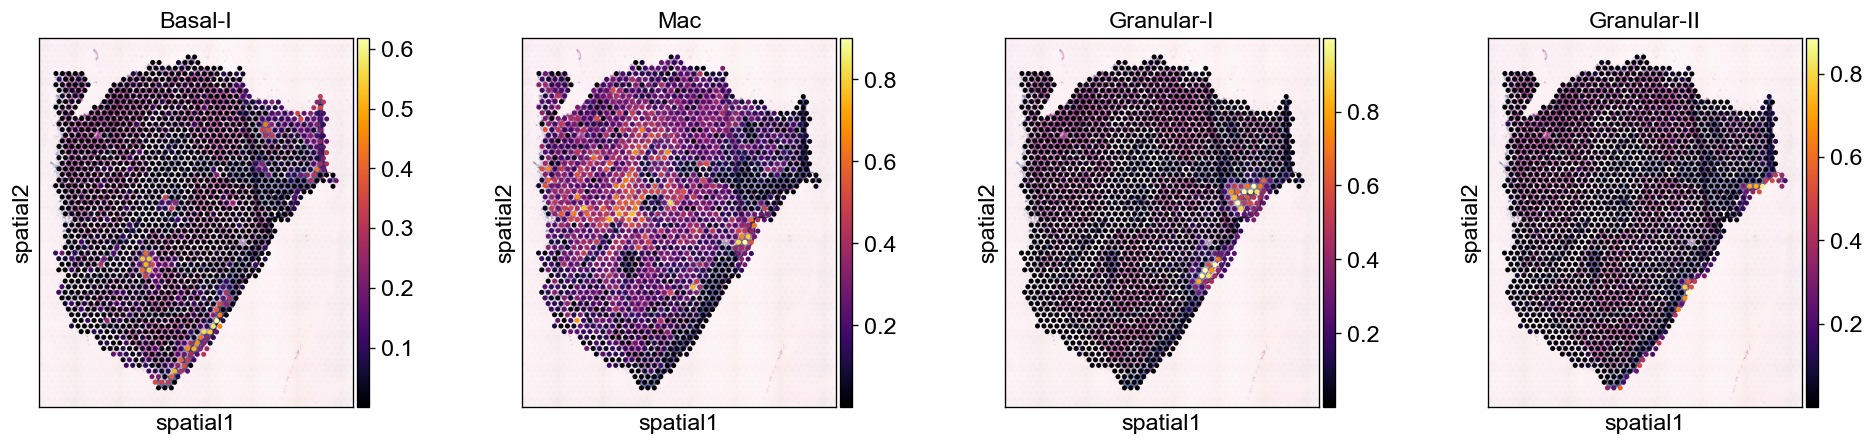

In [44]:
# low dpi for uploading to github
sc.settings.set_figure_params(dpi = 60, color_map = 'RdPu', dpi_save = 200, vector_friendly = True, format = 'svg')
sc.pl.spatial(st_adata, img_key = "hires", color = ['Basal-I','Mac',"Granular-I", "Granular-II"], size = 1.2, color_map = 'inferno')

In [40]:
st_adata.obsm["deconvolution"].columns

Index(['B-cell', 'Basal-I', 'Basal-II', 'Basal-III', 'Basal-IV', 'DC', 'FB-I',
       'FB-II', 'FB-III', 'FB-IV', 'Granular-I', 'Granular-II', 'LC', 'LE',
       'MEL', 'Mac', 'Mast-cell', 'Mono-DC', 'Mono-Mac', 'NK-cell', 'PC-vSMC',
       'Schwann', 'Spinous-I', 'Spinous-II', 'Spinous-III', 'Th', 'VE'],
      dtype='object')

In [111]:
#sc_model.adata.write_h5ad("test.h5ad")
#sc_adata.write_h5ad("test.h5ad")

# cannot save as h5ad
# ValueError: '_index' is a reserved name for dataframe columns.

# colname of sc_data.var is "_index"
# is when changing names for rawdata.var, need to fix!
adata_sc.write_h5ad("test.h5ad")

... storing 'Patient' as categorical
... storing 'Gender' as categorical
... storing 'Doublet' as categorical
... storing 'Phase' as categorical
... storing 'cl.annot' as categorical
